# Data 5 | Supplemental Material

In [1]:
from data5_supplemental import *

## Phone Numbers and Semi-Automated Texting

To do anything involving contacting voters, I first need IRB approval since it's research involving human subjects.

https://en.wikipedia.org/wiki/Area_codes_336_and_743#/media/File:USA_telephone_area_code_map_-_North_Carolina.svg

And to legally contact voters I need to send the text message manually. Auto-texters are banned. But according to the fcc:

"political text messages can be sent without the intended recipient’s prior consent if the message’s sender does not use autodialing technology to send such texts and instead manually dials them"

https://www.fcc.gov/rules-political-campaign-calls-and-texts

After doing some reading, it sounds as if call-center type software is allowed, but the opporator is required to click send. One source claims they can send up to 800 texts per hour, which is 13 texts per minute. Not sure how much software is involved ... or is allowed to be involved.

https://stonesphones.com/blog/voter-file-texting-what-you-should-know/

Here's a document with more specific language:

https://bolderadvocacy.org/wp-content/uploads/2016/02/AFJ_Rules-of-Robo_web2-1.pdf

This is the map of phone area codes

https://en.wikipedia.org/wiki/Area_codes_336_and_743#/media/File:USA_telephone_area_code_map_-_North_Carolina.svg

## Spatial Interpolation using Squares

This used to be part of data3. I've simply coppied the code from data3 here and into the import file without modification.

In [ ]:
meterlist = [50,75,100,150,250,500,1000,2000]
folder,state,meters,print_log = 'data3_neighborhoods/','NC',meterlist[5],{}
path = 'data3_neighborhoods/'+state+'/'

meta_yearlist = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2015,2016,2017,2018,2019][::-1]
yearlist = meta_yearlist

#nc_acs_summary = return_nc_acs_summary()

""" Step 0 | Setup """
data_name = state+' @ '+str(meters)+'m'
print_log[data_name] = {'log':[]}

if 'Ad_'+str(meters)+'m.pkl' in os.listdir(folder+state+'/'):
    print_log[data_name]['log'] = ['  Step 0 | Load Grid']
    printer(print_log)
    with open(folder+state+'/WHd_'+str(meters)+'m.pkl','rb') as f: WHd = pickle.load(f)
    with open(folder+state+'/Ad_'+str(meters)+'m.pkl','rb') as f: Ad = pickle.load(f)
    with open(folder+state+'/Cd_'+str(meters)+'m.pkl','rb') as f: Cd = pickle.load(f)
else:
    print_log[data_name]['log'] = ['  Step 0 | Generate Grid']
    printer(print_log)
    data = clean_data(state,2010)
    W,H = define_squares(data,meters)
    Ad,WHd,Cd = adjacency_matrix(W,H,data_name,print_log,path)
    with open(folder+state+'/WHd_'+str(meters)+'m.pkl','wb') as f: pickle.dump(WHd, f)
    with open(folder+state+'/Ad_'+str(meters)+'m.pkl','wb') as f: pickle.dump(Ad, f)
    with open(folder+state+'/Cd_'+str(meters)+'m.pkl','wb') as f: pickle.dump(Cd, f)

for year in yearlist:
    T0 = time.time()
    data_name = str(year)#state+' '+str(year)+' - '+str(meters)+'m'
    print_log[data_name] = {'log':[],'sublog':[]}
    printer(print_log)
    
    if 'voters_'+str(year)+'_'+str(meters)+'m.csv' in os.listdir(path):
        print_log[data_name]['log'].append('  Done')
        printer(print_log)
        
    if 'voters_'+str(year)+'_'+str(meters)+'m.csv' not in os.listdir(path):
        
        """ Step 1 | Open and Clean """
        t0 = time.time()
        print_log[data_name]['log'].append('  Step 1 | Open and Clean')
        printer(print_log)
        data = clean_data(state,year)
        print_log[data_name]['log'][-1] = '  Step 1 | Open and Clean (Runtime: '+str(round((time.time()-t0)/60))+' mins)'
        
        """ Step 2 | Populate Squares """
        t0 = time.time()
        print_log[data_name]['log'].append('  Step 2 | Populating Squares')   
        SNd,POPd = populate_squares(data,WHd,print_log,data_name,meters)
        print_log[data_name]['log'][-1] = '  Step 2 | Populating Squares (Runtime: '+str(round((time.time()-t0)/60))+' mins; Squares: '+str(len(SNd))+')'
        del data
        
        """ Step 3 | Spatial Interpolation """
        """
        t0 = time.time()
        print_log[data_name]['log'].append('  Step 3 | Spatial Interpolation')
        SNd_int = spatial_interpolate(SNd,nc_acs_summary,data_name,print_log,year)
        print_log[data_name]['log'][-1] = '  Step 3 | Spatial Interpolation (Runtime: '+str(round((time.time()-t0)/60))+')'
        """
        
        """ Step -1 | Merge and Save """
        print_log[data_name]['log'].append('  Step -1 | Merge and Save')
        with open('data3_neighborhoods/'+state+'/SNd_'+str(year)+'_'+str(meters)+'m.pkl','wb') as f: pickle.dump(SNd, f)
        with open('data3_neighborhoods/'+state+'/POPd_'+str(year)+'_'+str(meters)+'m.pkl','wb') as f: pickle.dump(POPd, f)
        SNfinal = [SNd[i] for i in SNd]
        SNfinal = pd.concat(SNfinal,ignore_index=True, sort=False)
        SNfinal.to_csv('data3_neighborhoods/'+state+'/voters_'+str(year)+'_'+str(meters)+'m.csv')
        print_log[data_name]['log'][-1] = '  Step -1 | Merge and Save (Total Runtime: '+str(round((time.time()-T0)/60))+' mins)'
        printer(print_log)

### Example Visualization

In [25]:
year = 2018
state = 'PA'
grid_size = 5000 # meters

filepath1 = 'data1/'+state+'/'+state+'_'+str(year)+'/'
filepath4 = 'data4/'+state+'/'+state+'_'+str(year)+'/'+str(grid_size)+'/'

for county_name in ['ADAMS']:    
    print(county_name)
    print('  Grid Size:',grid_size,'m')
    t0 = time.time()
    
    # ACS Statistics

    neighborhoods = gpd.read_file(filepath4+county_name+'/neighborhoods.shp')
    neighborhoods.crs = {'init': 'epsg:3395'}
    neighborhoods = neighborhoods.to_crs({'init' :'epsg:4269'})
    
    # maybe consider changing the projection
    # map_crs = {'init':'epsg:3395', 'units':'m'}
    
    print('  Neighborhoods:',len([x for x in neighborhoods.iterrows()]))
    t0 = time.time()

    X = []
    neighborhood_list = neighborhoods.iterrows()
    
    n = [x for x in neighborhood_list][0]
        
    n_geo = n[1]['geometry']
    zip_intersection = county_file.intersection(n_geo)

    index = gpd.GeoDataFrame([county_file.iloc[i] for i in county_file.index if zip_intersection.iloc[i].area > 0])
    index.loc[:,'intersect_area'] = [i.area for i in zip_intersection if i.area > 0]
    index.loc[:,'area'] = [index.geometry.iloc[i].area for i in range(len(index))]
    index.loc[:,'perc_intersect'] = index['intersect_area']/index['area']
    index.loc[:,'perc_land'] = index['ALAND10']/(index['ALAND10']+index['AWATER10'])

    X_sub = [n[0]]
    for col in pop_cols:
        X_sub.append(sum(index[col]*index['perc_intersect']))
    #for col in inc_cols:
    #    X_sub.append(sum(index[col]*index['perc_intersect']))
    X_sub.append(sum(index['perc_land']*index['perc_intersect']))

ADAMS
  Grid Size: 5000 m
  Neighborhoods: 93


In [26]:
index['Total']

979     11567
1005    29525
1022     5619
1049     3667
Name: Total, dtype: int64

In [27]:
index['perc_intersect']

979     0.174511
1005    0.025144
1022    0.046004
1049    0.044828
Name: perc_intersect, dtype: float64

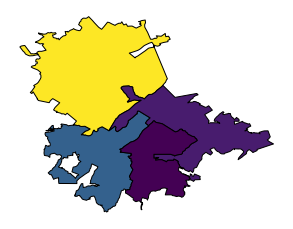

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
index.plot(ax=ax, edgecolor='black',column='Total')
#gpd.GeoDataFrame([n[1]]).plot(ax=ax, color='grey', alpha=0.8)
#zip_intersection.plot(ax=ax, color='grey', alpha=0.9, edgecolor='black')
ax.set_axis_off()
plt.savefig('figures/acs_1.pdf')

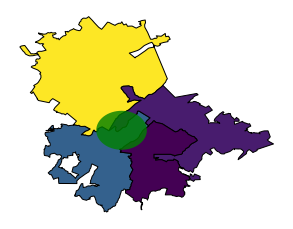

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
index.plot(ax=ax, edgecolor='black',column='Total')
gpd.GeoDataFrame([n[1]]).plot(ax=ax, color='green', alpha=0.8)
#zip_intersection.plot(ax=ax, color='grey', alpha=0.9, edgecolor='black')
ax.set_axis_off()
plt.savefig('figures/acs_2.pdf')

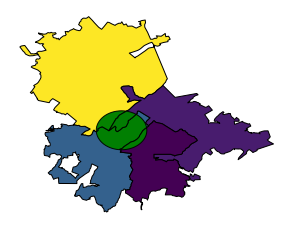

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
index.plot(ax=ax, edgecolor='black',column='Total')
gpd.GeoDataFrame([n[1]]).plot(ax=ax, color='green', alpha=0.8)
zip_intersection.plot(ax=ax, color='green', alpha=0.9, edgecolor='black')
ax.set_axis_off()
plt.savefig('figures/acs_3.pdf')

In [ ]:
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
# https://web.stanford.edu/~jrodden/jrhome_files/electiondata.htm
# https://projects.iq.harvard.edu/eda/data
# https://www.pavoterservices.pa.gov/Pages/PollingPlaceInfo.aspx

## Geography and Population

In [5]:
county_population = pd.read_csv('data0_raw/nhgis/county_population/nhgis0001_county.csv', encoding='latin-1')
col_rename = {x:'POP_'+x.replace('A00AA','') for x in county_population.columns.values[7:]}
col_rename_names = [col_rename[x] for x in col_rename if int(col_rename[x].replace('POP_','')) >= 1920]
keep_cols = ['GISJOIN','STATE','COUNTY','COUNTYNH'] + col_rename_names
county_population = county_population.rename(columns=col_rename)

county_shapefile = gpd.read_file('data0_raw/nhgis/county_shape/us_county_2000/US_county_2000.shp')
keep_cols = ['NHGISNAM', 'ICPSRCTY', 'STATENAM', 'GISJOIN', 'SHAPE_AREA', 'geometry'] + col_rename_names
counties = county_population.merge(county_shapefile, on='GISJOIN')[keep_cols].reset_index(drop=True)

for col in [col_rename[x] for x in col_rename if int(col_rename[x].replace('POP_','')) >= 1920]:
    counties['DENS_'+col.replace('POP_','')] = counties[col]/counties['SHAPE_AREA']
nc_counties = counties[counties.STATENAM == 'North Carolina'].reset_index(drop=True)
gpd.GeoDataFrame(counties).to_file('data6_supplemental/counties.shp')

## Webscrape County Voting Data

In [598]:
# https://en.wikipedia.org/wiki/United_States_presidential_elections_in_Washington,_D.C.
# This doesn't work perfectly. There are many years for many states that aren't getting collected despite being present.
# It might be worth doing this individually by state-year for specific states.

#state_names_alt = ["Alaska"]
yearlist = np.arange(1940,2020,4)
state_elections = {}

for state in state_names:
    state = state.replace(' ','_')
    state_elections[state] = {}
    for year in yearlist:
        url = "https://en.wikipedia.org/wiki/"+str(year)+"_United_States_presidential_election_in_"+state
        try:
            table_list = pd.read_html(url)
            clean_up = False
            for table in table_list:
                col_names = list(table.columns.values)
                if type(col_names[0]) == str:
                    if ('County' in col_names[0]) or ('Parish' in col_names[0]):
                        table['state'] = state
                        state_elections[state][year] = table
                        clean_up = True
                if type(col_names[0]) == tuple:
                    for subcol_name in col_names[0]:
                        if ('County' in subcol_name) or ('Parish' in subcol_name):
                            table['state'] = state
                            state_elections[state][year] = table
                            clean_up = True
                            
            if clean_up == True:
                table = state_elections[state][year]
                col_names = table.columns.values
                selected_cols = [table.columns.values[0], table.columns.values[-1]]
                for col in col_names:
                    if type(col) == tuple:
                        for subcol in col:
                            #if '%' in table[col].iloc[0]:
                            #    selected_cols.append(col)
                            if '%' in subcol:
                                selected_cols.append(col)
                            if 'Percentage' in subcol:
                                selected_cols.append(col)
                            if 'percentage' in subcol:
                                selected_cols.append(col)
                    if type(col) == str:
                        if '%' in col:
                            selected_cols.append(col)
                        if 'Percentage' in col:
                            selected_cols.append(col)
                        if 'percentage' in col:
                            selected_cols.append(col)
                table = table[selected_cols]
                table.columns = table.columns.map(''.join)
                rename_dict = {col:rename_columns(col,year) for col in table.columns}
                table = table.rename(columns = rename_dict)

                index_names = table[table['County'].isin(['Totals','Total','All '])].index
                table.drop(index_names, inplace=True)

                table = table.sort_values(by='County', ignore_index=True)
                table = table[[rename_dict[x] for x in rename_dict if rename_dict[x] != 'O']]
                for col in [x for x in table.columns.values if (x != 'County') & (x != 'state')]:
                    table[col] = [float(str(x).strip('%w').replace('Source: [20]', 'nan')) for x in table[col]]
                table['State_County'] = table['state'] +'|'+ table['County']

                state_elections[state][year] = table
        except:
            pass

In [540]:
datalist,datadict = {},[]
for state in state_elections:
    try:
        state_datalist = [state_elections[state][year].set_index('County') for year in state_elections[state] if 'D_'+str(year) in state_elections[state][year].columns.values] #.set_index('State_County')[['D_'+str(year),'R_'+str(year)]]
        datalist.append(state_datalist)
        print(state)
    except:
        try:
            state_datalist = [state_elections[state][year].set_index('Parish') for year in state_elections[state] if 'D_'+str(year) in state_elections[state][year].columns.values] #.set_index('State_County')[['D_'+str(year),'R_'+str(year)]]
            datalist.append(state_datalist)
        except:
            print(state)
    try:
        concat_list = pd.concat(state_datalist,axis=1)
        concat_list.to_csv('data6_supplemental/state_vote_share/'+state+'.csv')
        datadict[state] = concat_list
    except:
        print('sub '+state)

Virginia
sub Virginia


In [560]:
datalist = [elections[year].set_index('State_County') for year in elections]
election_hist = pd.concat(datalist, axis=1)
index_names = list({x for x in election_hist.index if ('All ' in x) or ('Total' in x)})
election_hist.drop(index_names, inplace=True)
election_hist['State_County'] = election_hist.index
election_hist = election_hist.reset_index(drop=True)
election_hist.to_csv('data6_supplemental/election_hist_raw.csv')

election_hist['State_County'] = [x.replace('_',' ') for x in election_hist['State_County']]
election_hist = election_hist.drop(columns=['County','state'])
election_hist['state'] = [x.split('|')[0] for x in election_hist['State_County'] if len(x.split('|'))==2]
election_hist['County'] = [x.split('|')[1] for x in election_hist['State_County'] if len(x.split('|'))==2]
election_hist.to_csv('data6_supplemental/election_hist.csv')

## Vote Share and Density

In [564]:
counties['STATENAM'] = [x.replace('_',' ') for x in counties['STATENAM']]
counties['State_County'] = counties['STATENAM'] +'|'+ counties['NHGISNAM']

vote_share_density = counties.merge(election_hist, on='State_County')
vote_share_density.to_csv('electoral_divergence_d/vote_share_density.csv')

## Census & ACS PUMAs

In [20]:
census = pd.read_csv('data0_raw/census/census_1980_2000.csv')
census = census.dropna(subset=['puma'])
census.puma = census.puma.astype(int)
nc_census = census[census.statefip=='North Carolina']

acs = pd.read_csv('data0_raw/census/acs_2004_2019.csv')
acs = acs.dropna(subset=['puma'])
acs.puma = acs.puma.astype(int)
nc_acs = acs[acs.statefip=='North Carolina']

education = ['College','Some College','No College']

yearlist_census = list(nc_census.year.unique())
yearlist_acs = [x for x in nc_acs.year.unique() if x >=2005]
yeardict_census_acs = {year:np.nan for year in yearlist_census + yearlist_acs}

puma_yeardict = {year:year for year in yearlist_census + yearlist_acs}
for year in nc_puma_yearmap:
    if year in yearlist_census:
        puma_year = gpd.read_file('data0_raw/shapefiles/ipums_puma_'+str(year)+'/ipums_puma_'+str(year)+'.shp')
    if year < 2012:
        puma_year = gpd.read_file('data0_raw/shapefiles/ipums_puma_'+str(2000)+'/ipums_puma_'+str(2000)+'.shp')
    if year >= 2012:
        puma_year = gpd.read_file('data0_raw/shapefiles/ipums_puma_'+str(2010)+'/ipums_puma_'+str(2010)+'.shp')
        
    nc_puma_year = puma_year[puma_year.STATEFIP == '37']
    nc_puma_year.PUMA = nc_puma_year.PUMA.astype(int)
    puma_yeardict[year] = nc_puma_year

for year in yearlist_census + yearlist_acs:
    if year in yearlist_census:
        nc_year = nc_census[(nc_census.year == year)]
    if year in yearlist_acs:
        nc_year = nc_acs[(nc_acs.year == year)]
    
    nc_puma_list = [x for x in nc_year.puma.unique() if x >= 0]
    nc_puma = puma_yeardict[year]
    selected_pumas = nc_puma[nc_puma.PUMA.isin(nc_puma_list)]
    
    average_data = []
    for puma in nc_puma_list:
        averages,col_names = [puma],['puma']
        
        subdata = nc_year[(nc_year.puma == puma)]
        population = sum(subdata.perwt)
        white_pop = sum(subdata[subdata.race == 'White'].perwt)
        black_pop = sum(subdata[subdata.race == 'Black'].perwt)
        averages = averages + [population, white_pop, black_pop]
        col_names = col_names + ['POP','WHITE','BLACK']
        
        subdata = subdata[(subdata.age >= 18)]
        averages = averages + [sum(subdata.perwt)]
        col_names = col_names + ['VOTING_POP']
        
        subdata = subdata[(subdata.empstat != 'Not in labor force')]
        averages = averages + [sum(subdata.perwt)]
        col_names = col_names + ['LABOR']
        
        averages = averages + [sum(subdata.age*subdata.perwt)/sum(subdata.perwt), sum(subdata.trantime*subdata.perwt)/sum(subdata.perwt)]
        col_names = col_names + ['AGE', 'TRANTIME']
        
        for ed_type in education:
            ed_type_data = subdata[subdata.educ == ed_type]
            ed_type = ed_type.upper().replace(' ','_')
            averages = averages + [sum(ed_type_data.perwt)]
            col_names = col_names + [ed_type]
            
            ed_type_data = ed_type_data[ed_type_data.empstat == 'Employed']
            averages = averages + [sum(ed_type_data.perwt), sum(ed_type_data.incwage*ed_type_data.perwt)/sum(ed_type_data.perwt)]
            col_names = col_names + [ed_type+'_EMPLOYED', ed_type+'_WAGE']

        average_data.append(averages)
    average_data = pd.DataFrame(average_data, columns=col_names)
    
    selected_pumas = nc_puma[nc_puma.PUMA.isin(nc_puma_list)]
    selected_data = average_data[average_data.puma.isin(selected_pumas.PUMA.unique())]
    
    nc_puma_data = pd.concat([selected_pumas.sort_values(by='PUMA').reset_index(drop=True), selected_data.sort_values(by='puma').reset_index(drop=True)], axis=1)

    nc_puma_data['AREA'] = nc_puma_data.area
    nc_puma_data['DENSITY'] = nc_puma_data['POP']/nc_puma_data['AREA']
    
    yeardict_census_acs[year] = nc_puma_data
with open('data6_supplemental/yeardict_census_acs.pkl','wb') as f: pickle.dump(yeardict_census_acs, f)